In [1]:
import time
import torch
import numpy as np
from multiprocessing import Pool

#from ENV import KYenv
from ENV import DHenv as Env
from DRQN_controller import DRQN_Agent
from DRQN_learner import QLearner
from DRQN_agent import decode_act,get_decay

import matplotlib.pyplot as plt

In [2]:
R = np.arange(1,56,0.2)
PL = 38.46 + 20*np.log10(R) + 0.7 * R + 10
pw = 10
noise = -85
SNR = pw - PL - noise

(1.0, 50.0)

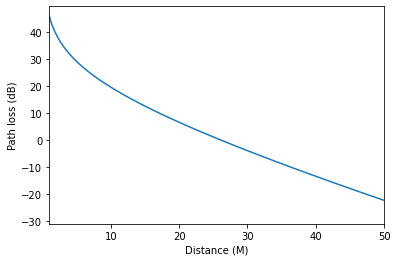

In [4]:
plt.plot(R, SNR)
plt.xlabel("Distance (M)")
plt.ylabel("Path loss (dB)")
plt.xlim([1,50])


In [2]:
# Generate the original position of UEs

#t_ues = torch.rand(10, 2) * torch.Tensor([40, 40])
#print(t_ues)
t_ues = torch.tensor([[ 2.3219, 35.5963],
        [ 4.9058,  7.3772],
        [34.1434, 24.6237],
        [30.3456, 22.6246],
        [26.9648, 20.9890],
        [19.2420, 32.8353],
        [12.3929, 39.7321],
        [ 5.9339, 29.5289],
        [33.2905, 37.5042],
        [ 9.2728, 15.3940]])


In [3]:
# initialize environments, agents and learner

# initialize environment
#env = KYenv(4, 24, 500)
env = Env(border=torch.Tensor([40, 40]),
          enbs = torch.Tensor([[10, 10, 10],
                               [10, 30, 10],
                               [10, 10, 30],
                               [10, 30, 30]]),
          ues = t_ues,
          noise = 10**(-11.5),
          # rw = 0.01
          )

# set saving directory/name
filename = 'AP4UE10Act5_DRQN.pkl'
# enable cuda in training
cuda_flag = True

# initialize learner
controller = DRQN_Agent(input_shape=64, n_actions=625) #n_actions = 6 * 5, input_shape = 11
# controller.save('models/' + filename)
learner = QLearner(controller,device="cuda",batch_size=32,num_feats=64)
if cuda_flag:
    learner.cuda()

# initialize test learner
test_controller = DRQN_Agent(input_shape=64, n_actions=625) #n_actions = 6 * 5, input_shape = 11
test_controller.load('models/' + filename)
test_controller.cuda()
test_controller.init_hidden(batch_size=1)


reward = 0


In [4]:
#epi_length = 0
#epi_length_step = 100

# set batch size
batch_size = 8
epi_step = 0
total_step = 0
best = 0


# initialze reward and loss saving container
r_history = []
loss_history = []

In [10]:
max_epi_iter = 100
max_MC_iter = 64
learner.set_sgd(1e-4)
# controller.load("././models/drqn_best_5.pkl")



for epi_iter in range(max_epi_iter):
    env.reset()
    losses = []
    rewards = []
    epi_step += 1

    for MC_iter in range(max_MC_iter):
        # env.render()
        total_step += 1
        obs = []
        for j in range(env.n_enbs):
            obs.append(env.get_agent_obs(j))
        obs = torch.stack(obs, dim=0)
        obs = torch.flatten(obs)
        controller.init_hidden(1)
        action = controller.get_action(torch.reshape(obs,(1,64)).cuda(),
                                               0.3)
        act = decode_act(action,4,5)
        s_t1,r = env.step(act)
        s_t1 = torch.flatten(s_t1)
        controller.init_hidden(512)
        loss, grad = learner.train(obs.numpy(), action,
                                   r.item(), s_t1.numpy(), total_step)
        if loss is not None:
            losses.append(loss.item())


    learner._update_targets()

    # Save the results
    if losses != []:
        loss_history.append(np.mean(losses))

    # save and update the test controller
    controller.save('models/' + filename)
    test_controller.load('models/' + filename)



    for test_round in range(max_MC_iter):

        obs = []
        for j in range(env.n_enbs):
            obs.append(env.get_agent_obs(j))
        obs = torch.stack(obs, dim=0)
        obs = torch.flatten(obs)
        action = test_controller.get_action(
            torch.reshape(obs,(1,64)).cuda(), 0.0)
        act = decode_act(action,4, 5)
        s_t1,r = env.step(act)
        rewards.append(r)



    # save test reward
    r_history.append(np.mean(rewards))



    print('Episode', epi_iter, 'reward', np.mean(rewards), "\n loss",
          np.mean(losses),  "grad_norm", grad)
    if np.mean(rewards) > best and epi_step > 10:
        best = np.mean(rewards)
        print(f"Current best {best}! Saving.... ")
        test_controller.save("./models/drqn_best_5.pkl")


    # For DQN, it is necessary to update the target network, maybe not important for you

    if (epi_iter + 1) % 50 == 0:
        plt.plot(r_history)
        plt.show()

        plt.plot(loss_history)
        plt.show()


Episode 0 reward 19.293806 
 loss 0.10866947152784892 grad_norm None
Episode 1 reward 20.529655 
 loss 0.09176110724608104 grad_norm None
Episode 2 reward 21.852776 
 loss 0.10897738167217799 grad_norm tensor(2.7835, device='cuda:0')
Current best 21.85277557373047! Saving.... 
Episode 3 reward 20.611004 
 loss 0.10362709624071915 grad_norm None
Episode 4 reward 21.300648 
 loss 0.09209070044259231 grad_norm None
Episode 5 reward 21.560446 
 loss 0.07166254680071558 grad_norm None


KeyboardInterrupt: 

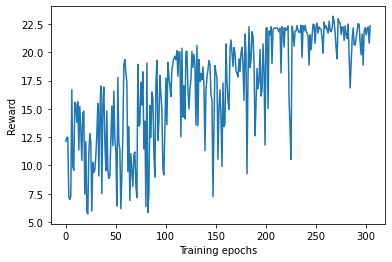

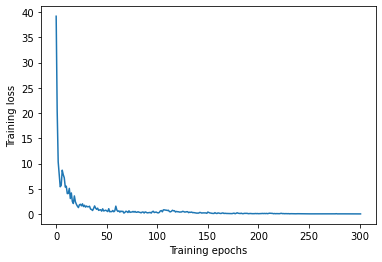

In [35]:

plt.plot(r_history)
plt.xlabel("Training epochs")
plt.ylabel("Reward")
plt.savefig("training_reward_5_rw.png")
plt.show()

plt.plot(loss_history)
plt.xlabel("Training epochs")
plt.ylabel("Training loss")
plt.savefig("training_loss_5_rw.png")
plt.show()

In [26]:
inds = [
    [1,3,4,7,9],
    [1,2,3,4,9],
    [0,5,6,7,9],
    [2,3,4,5,8]
        ]


[1,3,4,5,9]

[]


In [5]:
def draw(env, size_on=True, serve_on=True):
        # draw UEs position
    plt.figure(dpi=100, figsize=[5, 5])
    plt.xlim(0, env.border[0])
    plt.ylim(0, env.border[1])
    t_ues = env.ues_pos
    if size_on:
        t_size = env.MA_rate.numpy()
    else:
        t_size = 5

    print(t_size.shape, t_ues.shape)

    plt.scatter(t_ues[:, 0], t_ues[:, 1], s = np.transpose(t_size * 100))

    if serve_on:
       plt.scatter(env.enbs_pos[:,0],env.enbs_pos[:,1],marker="x",s = 200)
    plt.show()

In [11]:
# random test
gamma = 0.98
test_controller.load("./models/drqn_best_5.pkl")


rl = []
for _ in range(20):
    obs = env.reset()
    r = 0.0
    dup = 0
    for t in range(500):
        obs = []
        ind = set()
        inds = []
        env.get_global_obs()
        for j in range(env.n_enbs):
            obs.append(env.get_agent_obs(j))
            inds.append(obs[j][:,0])
        obs = torch.stack(obs, dim=0)

        obs = torch.flatten(obs)
        action = test_controller.get_action(torch.reshape(obs,(1,64)).cuda(),0.0)
        act = decode_act(action,4,5)
        for k in range(4):
            if act[k] != 4:
                ind.add(inds[k][act[k]])
            else:
                ind.add(k + 100)
        if len(ind) < 4:
            dup += 1
        s_t1,reward = env.step(act)
        r += (1 - gamma) * (reward - r)
        if (t + 1) % 100 == 0:
            draw(env)
    rl.append(r)
    print(dup / 500)


print(np.mean(rl), np.std(rl))



KeyboardInterrupt: 

(10,) torch.Size([10, 2])


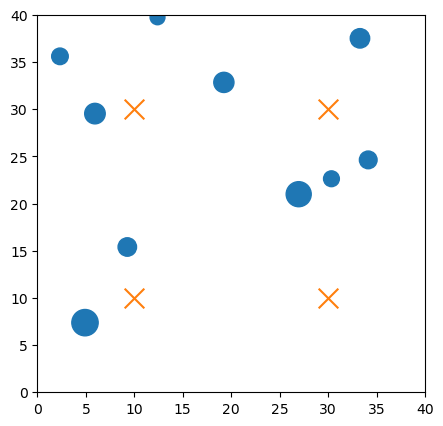

In [16]:
draw(env)